In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math



In [3]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [4]:
print("Loading data...")
train_data = pd.read_table("Desktop/cc/train.tsv")
test_data = pd.read_table("Desktop/cc/test_stg2.tsv")
print(train_data.shape)
print(test_data.shape)

Loading data...
(1482535, 8)
(3460725, 7)


In [5]:
train_data = train_data.drop(["item_condition_id","shipping"],axis="columns") 
test_data = test_data.drop(["item_condition_id","shipping"],axis="columns")

train_data 

,train_id,name,category_name,brand_name,price,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,NaN,10.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,Electronics/Computers & Tablets/Components & P...,Razer,52.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,Women/Tops & Blouses/Blouse,Target,10.0,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,NaN,35.0,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,NaN,44.0,Complete with certificate of authenticity
...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,Women/Dresses/Mid-Calf,Free People,20.0,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,Kids/Girls 2T-5T/Dresses,Disney,14.0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,Home/Home Décor/Home Décor Accents,NaN,45.0,There is 2 of each one that you see! So 2 red ...


In [7]:
%%time
# attempt to find missing brand names

train_data.brand_name.fillna(value="missing", inplace=True)
test_data.brand_name.fillna(value="missing", inplace=True)

unique_brand_names = set(train_data.brand_name.unique()).union(set(test_data.brand_name.unique()))

# get to finding!
premissing = len(train_data.loc[train_data['brand_name'] == 'missing'])
def brandfinder(line):
    brand = line[0]
    name = line[1]
    if brand == 'missing':
        for brand_name in unique_brand_names:
            if brand_name in name and len(brand_name)>2:
                return brand_name
    return brand

Wall time: 561 ms


In [8]:
%%time
train_data['brand_name'] = train_data[['brand_name','name']].apply(brandfinder, axis = 1)
test_data['brand_name'] = test_data[['brand_name','name']].apply(brandfinder, axis = 1)
found = premissing-len(train_data.loc[train_data['brand_name'] == 'missing'])
print(found)

203075
Wall time: 15min 35s


In [9]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train_data = handle_missing(train_data)
test_data = handle_missing(test_data)
print(train_data.shape)
print(test_data.shape)

Handling missing values...
(1482535, 6)
(3460725, 5)


In [1]:
train_data.head(10)


NameError: name 'train_data' is not defined

In [11]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train_data.category_name, test_data.category_name]))
train_data.category_name = le.transform(train_data.category_name)
test_data.category_name = le.transform(test_data.category_name)

le.fit(np.hstack([train_data.brand_name, test_data.brand_name]))
train_data.brand_name = le.transform(train_data.brand_name)
test_data.brand_name = le.transform(test_data.brand_name)
del le

train_data.head(3)

Handling categorical variables...


,train_id,name,category_name,brand_name,price,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,864,3514,10.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,87,4660,52.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1320,5489,10.0,Adorable top with a hint of lace and a key hol...


In [12]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train_data.item_description.str.lower(), train_data.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train_data["seq_item_description"] = tok_raw.texts_to_sequences(train_data.item_description.str.lower())
test_data["seq_item_description"] = tok_raw.texts_to_sequences(test_data.item_description.str.lower())
train_data["seq_name"] = tok_raw.texts_to_sequences(train_data.name.str.lower())
test_data["seq_name"] = tok_raw.texts_to_sequences(test_data.name.str.lower())
train_data.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,category_name,brand_name,price,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,864,3514,10.0,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,87,4660,52.0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1320,5489,10.0,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [13]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train_data.seq_name.apply(lambda x: len(x))), np.max(test_data.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train_data.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test_data.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


<AxesSubplot:>

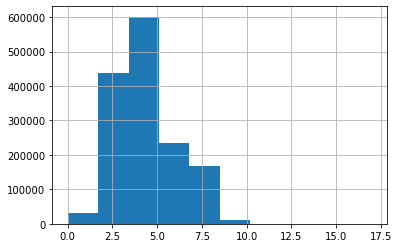

In [14]:
train_data.seq_name.apply(lambda x: len(x)).hist()


<AxesSubplot:>

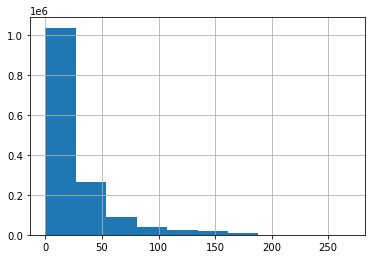

In [15]:
train_data.seq_item_description.apply(lambda x: len(x)).hist()


In [16]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train_data.seq_name.max())
                   , np.max(test_data.seq_name.max())
                  , np.max(train_data.seq_item_description.max())
                  , np.max(test_data.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train_data.category_name.max(), test_data.category_name.max()])+1
MAX_BRAND = np.max([train_data.brand_name.max(), test_data.brand_name.max()])+1


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

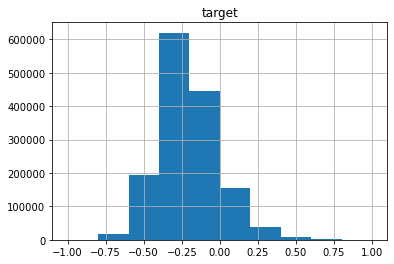

In [17]:
#SCALE target variable
train_data["target"] = np.log(train_data.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_data["target"] = target_scaler.fit_transform(np.array(train_data.target).reshape(-1,1))
pd.DataFrame(train_data.target).hist()

In [18]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train_data, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 9)
(14826, 9)


In [19]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
       
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test_data)

In [20]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , rnn_layer1
        , rnn_layer2
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 name (InputLayer)              [(None, 10)]         0           []                               
                                                                                              

In [21]:
pip install pydot

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 281s 3s/step - loss: 0.0266 - mae: 0.1239 - rmsle_cust: 0.0152 - val_loss: 0.0190 - val_mae: 0.1049 - val_rmsle_cust: 0.0137
Epoch 2/5
74/74 [==============================] - 251s 3s/step - loss: 0.0180 - mae: 0.1016 - rmsle_cust: 0.0133 - val_loss: 0.0169 - val_mae: 0.0988 - val_rmsle_cust: 0.0129
Epoch 3/5
74/74 [==============================] - 55796s 764s/step - loss: 0.0161 - mae: 0.0961 - rmsle_cust: 0.0126 - val_loss: 0.0161 - val_mae: 0.0965 - val_rmsle_cust: 0.0125
Epoch 4/5
74/74 [==============================] - 270s 4s/step - loss: 0.0151 - mae: 0.0930 - rmsle_cust: 0.0121 - val_loss: 0.0159 - val_mae: 0.0959 - val_rmsle_cust: 0.0124
Epoch 5/5
74/74 [==============================] - 282s 4s/step - loss: 0.0145 - mae: 0.0910 - rmsle_cust: 0.0119 - val_loss: 0.0160 - val_mae: 0.0959 - val_rmsle_cust: 0.0124


In [24]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4866832881176941


In [25]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test_data[["test_id"]]
submission["price"] = preds

<ipython-input-25-77cb972dbd75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["price"] = preds


<AxesSubplot:>

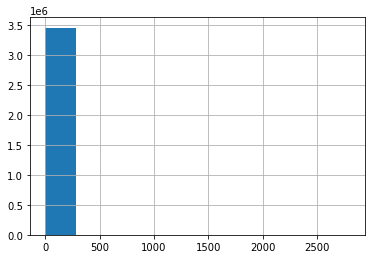

In [26]:
submission.to_csv("./simple_keras.csv", index=False)
submission.price.hist()